# Project 3

The purpose of this task is to train a neural network to control an inverted pendulum. For this reason, we will firstly solve the coupled ODE system, and then we can learn to balance the pendulum.

## Task 0: Import libraries

import libraries

In [ ]:
!pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.6/163.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 713.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
pip install torchdiffeq


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Task 1
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

# Task 2
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
import matplotlib.pyplot as plt
import equinox as eqx

## Task 1: Solve the coupled ODE system

The pendulum has the following ODE system

ODETerm(vector_field=<function pendulum_ode>)
Solution shape: (500, 4)


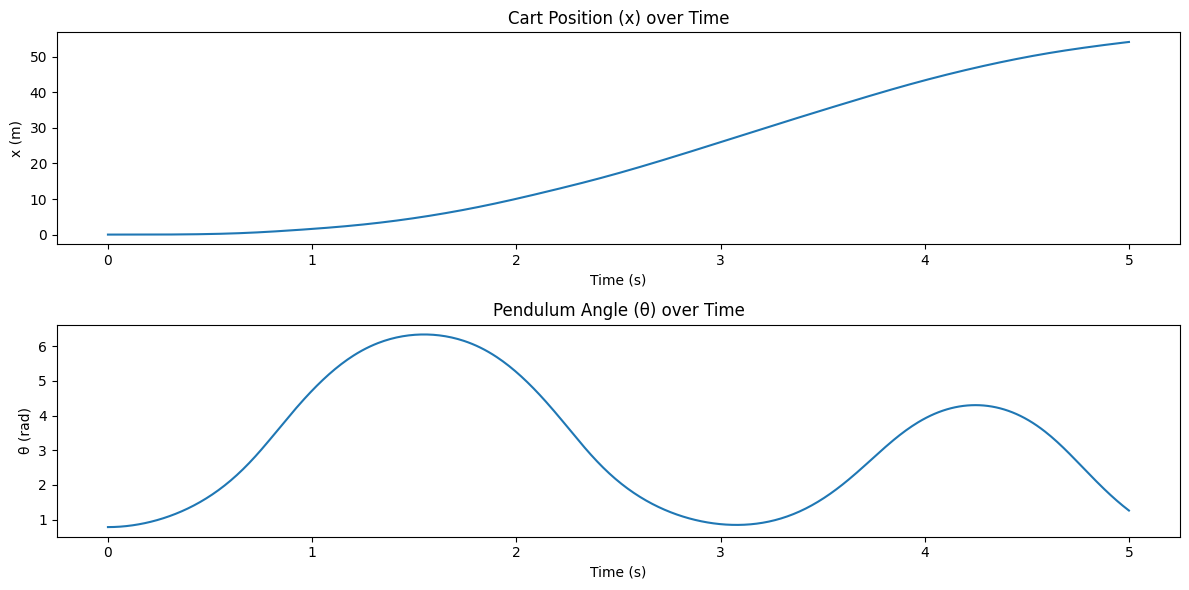

In [ ]:
# Define the parameters
M = 1.0
m = 0.1
l = 1.0
g = 9.81

# Define the external force function
def F(t):
    return 10 * jnp.sin(t)

# Define the system of ODEs
def pendulum_ode(t, y, args):
    x, x_dot, theta, theta_dot = y
    x_ddot = (F(t) - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * theta_dot**2 * jnp.sin(theta)) / (M + m - m * jnp.cos(theta)**2)
    theta_ddot = (g * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / l
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])

# Initial conditions (in order: x, x_dot, theta, theta_dot)
y0 = jnp.array([0.0, 0.0, jnp.pi / 4, 0.0])

# Time span
t0, tN = 0.0, 5.0
ts = jnp.linspace(t0, tN, 500)

# Solve the ODE
term = ODETerm(pendulum_ode)
print(term)
solver = Tsit5()
saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, saveat=saveat, max_steps=100000) # added the max_steps given there was an error in Colab otherwise

# Inspect the solution shape
print(f"Solution shape: {solution.ys.shape}")

x_sol = solution.ys[:, 0]
x_dot_sol = solution.ys[:, 1]
theta_sol = solution.ys[:, 2]
theta_dot_sol = solution.ys[:, 3]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(ts, x_sol)
plt.title('Cart Position (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')

plt.subplot(2, 1, 2)
plt.plot(ts, theta_sol)
plt.title('Pendulum Angle (θ) over Time')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')

plt.tight_layout()
plt.show()


It's possible to notice that the solution is of shape (500, 4), where 500 is the number of time steps and 4 corresponds to the variables. For this reason, it's possible to unpack the result.

If we want to have proper angles we have to change them

ODETerm(vector_field=<function pendulum_ode>)
Solution shape: (500, 4)


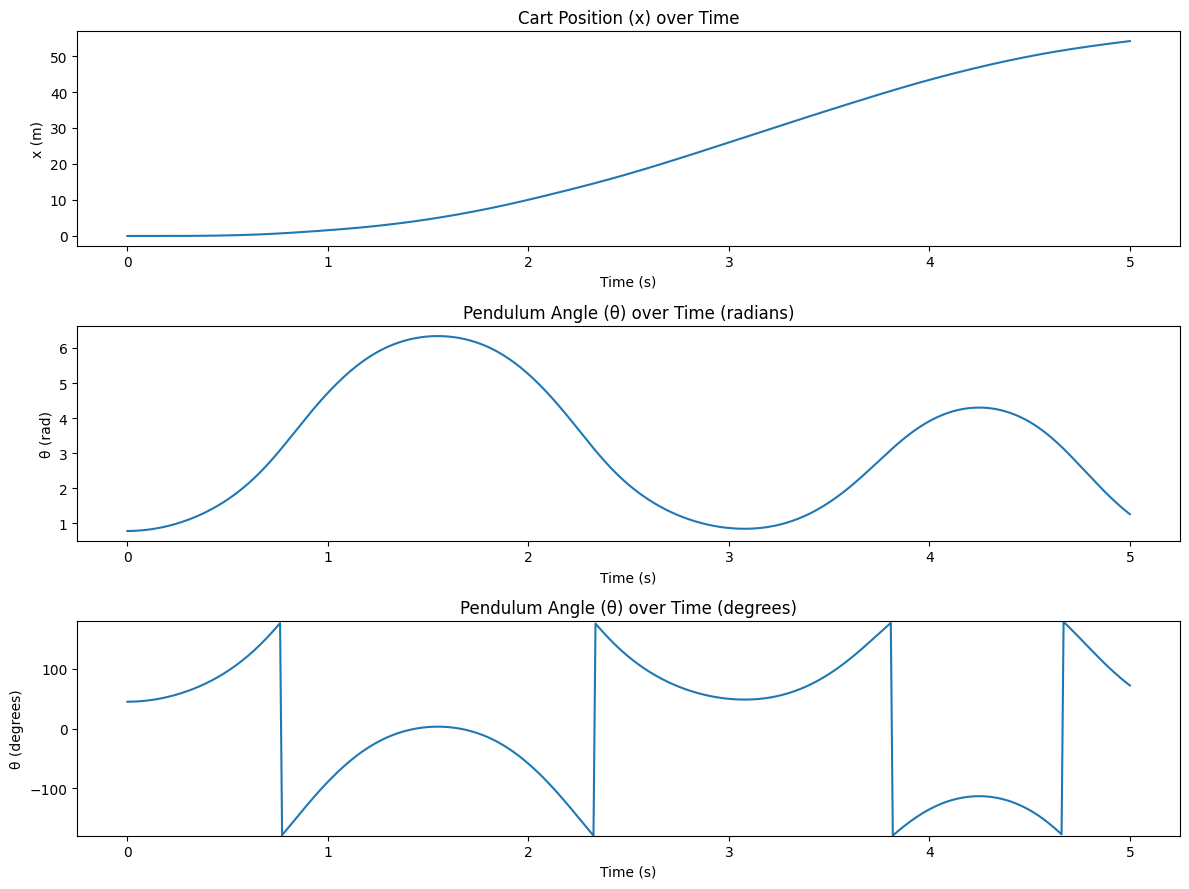

In [ ]:
# Define the parameters
M = 1.0
m = 0.1
l = 1.0
g = 9.81

# Define the external force function
def F(t):
    return 10 * jnp.sin(t)

# Define the system of ODEs
def pendulum_ode(t, y, args):
    x, x_dot, theta, theta_dot = y
    x_ddot = (F(t) - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * theta_dot**2 * jnp.sin(theta)) / (M + m - m * jnp.cos(theta)**2)
    theta_ddot = (g * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / l
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])

# Initial conditions (in order: x, x_dot, theta, theta_dot)
y0 = jnp.array([0.0, 0.0, jnp.pi / 4, 0.0])

# Time span
t0, tN = 0.0, 5.0
ts = jnp.linspace(t0, tN, 500)

# Solve the ODE
term = ODETerm(pendulum_ode)
print(term)
solver = Tsit5()
saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, saveat=saveat, max_steps=100000)

# Inspect the solution shape
print(f"Solution shape: {solution.ys.shape}")

x_sol = solution.ys[:, 0]
x_dot_sol = solution.ys[:, 1]
theta_sol = solution.ys[:, 2]
theta_dot_sol = solution.ys[:, 3]

# Convert theta to degrees and normalize to [-180, 180]
def normalize_angle_degrees(angle_rad):
    angle_deg = jnp.rad2deg(angle_rad)
    return ((angle_deg + 180) % 360) - 180

theta_sol_deg = normalize_angle_degrees(theta_sol)

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(ts, x_sol)
plt.title('Cart Position (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')

plt.subplot(3, 1, 2)
plt.plot(ts, theta_sol)
plt.title('Pendulum Angle (θ) over Time (radians)')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')

plt.subplot(3, 1, 3)
plt.plot(ts, theta_sol_deg)
plt.title('Pendulum Angle (θ) over Time (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('θ (degrees)')
plt.ylim(-180, 180)

plt.tight_layout()
plt.show()

## Task 2: Learning to balance the pendulum

This task builds upon the concepts explored in the previous one. The key difference lies in the introduction of a control aspect after a specific time, denoted as `t_c = 0.75 * tN`. At this point, the simulation problem transforms into a control problem. Our objective then becomes minimizing a loss function.

This approach resembles Linear-Quadratic Regulator (LQR) control, which utilizes the Riccati equation and other relevant equations to solve control problems.

Epoch 0, Loss: 3053.951171875
Epoch 100, Loss: 44.38439178466797
Epoch 200, Loss: 41.56576919555664
Epoch 300, Loss: 38.972564697265625
Epoch 400, Loss: 36.62112808227539
Epoch 500, Loss: 34.31793975830078
Epoch 600, Loss: 31.422555923461914
Epoch 700, Loss: 29.021188735961914
Epoch 800, Loss: 27.402847290039062
Epoch 900, Loss: 25.960708618164062


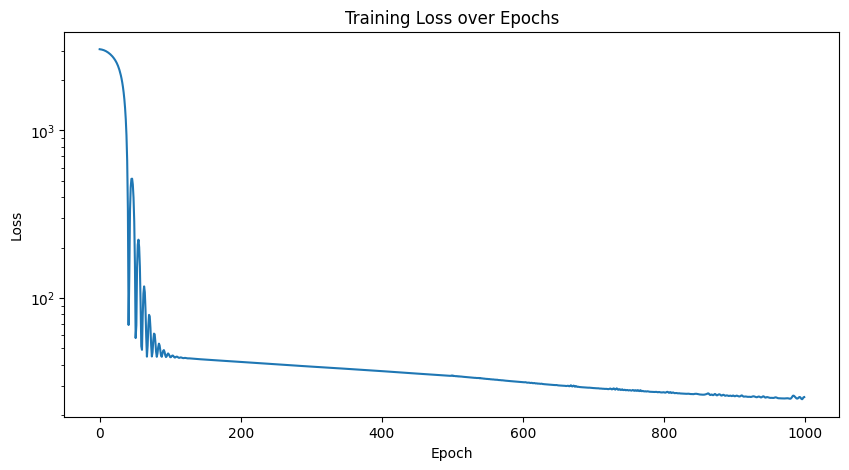

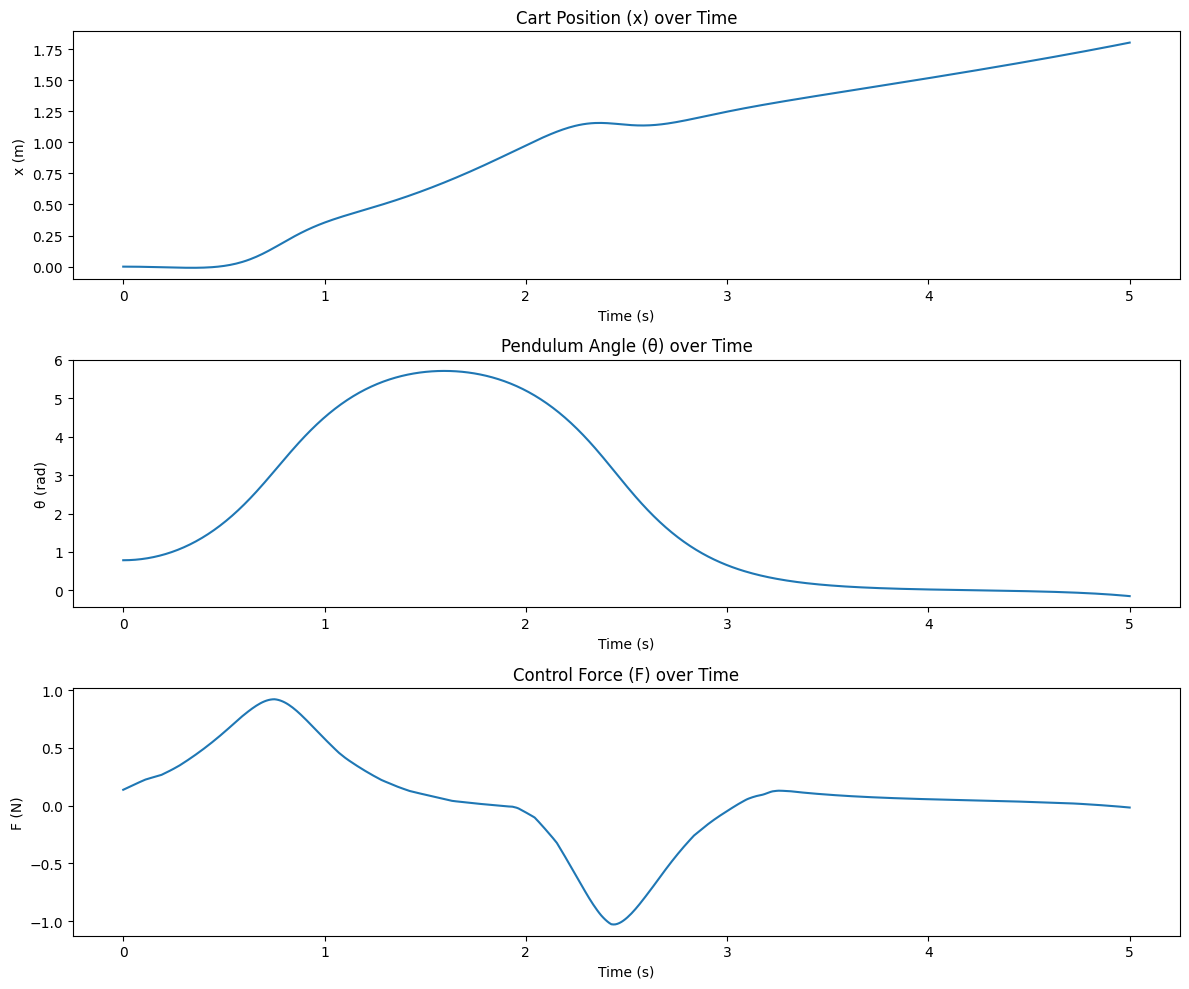

In [ ]:

# Define the neural network model using Equinox
class MLP(eqx.Module):
    layers: list
    final_layer: eqx.Module

    def __init__(self, key):
        keys = random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(4, 16, key=keys[0]),
            eqx.nn.Linear(16, 16, key=keys[1])
        ]
        self.final_layer = eqx.nn.Linear(16, 1, key=keys[2])

    def __call__(self, x):
        for layer in self.layers:
            x = jax.nn.relu(layer(x))
        x = self.final_layer(x)
        return x

# Initialize the model and parameters
key = random.PRNGKey(0)
mlp = MLP(key)

# Define the system of ODEs with neural network control
def pendulum_ode(t, y, mlp, M, m, l, g):
    x, x_dot, theta, theta_dot = y
    state = jnp.array([x, x_dot, theta, theta_dot])
    F = mlp(state).squeeze()  # Use the neural network to compute F
    x_ddot = (F - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * theta_dot**2 * jnp.sin(theta)) / (M + m - m * jnp.cos(theta)**2)
    theta_ddot = (g * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / l
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])

# Define the cost function
@jax.jit
def loss_fn(mlp, y0, t0, tN, ts, M, m, l, g):
    term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)
    x_sol = solution.ys[:, 0]
    x_dot_sol = solution.ys[:, 1]
    theta_sol = solution.ys[:, 2]
    theta_dot_sol = solution.ys[:, 3]
    # Calculate the index for the last fourth of the data
    last_fourth_index = int(3 * len(theta_sol) / 4)

    # Use only the last fourth of theta_sol for the loss calculation
    theta_sol_last_fourth = theta_sol[last_fourth_index:]

    state_sol = jnp.stack([x_sol, x_dot_sol, theta_sol, theta_dot_sol], axis=1)
    F_sol = jax.vmap(lambda state: mlp(state).squeeze())(state_sol)
    return jnp.sum(jnp.square(theta_sol_last_fourth)) + 0.3*jnp.sum(jnp.square(F_sol))

# Training setup
M = 1.0
m = 0.1
l = 1.0
g = 9.81
y0 = jnp.array([0.0, 0.0, jnp.pi / 4, 0.0])
t0, tN = 0.0, 5.0
ts = jnp.linspace(t0, tN, 500)

# Create the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

@jax.jit
def update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g):
    loss, grads = jax.value_and_grad(loss_fn)(mlp, y0, t0, tN, ts, M, m, l, g)
    updates, opt_state = optimizer.update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, loss

# Training loop
losses = []
for epoch in range(1000):
    mlp, opt_state, loss = update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Simulate with the trained policy
term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
solver = Tsit5()
saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)

# Extract solutions
x_sol = solution.ys[:, 0]
x_dot_sol = solution.ys[:, 1]
theta_sol = solution.ys[:, 2]
theta_dot_sol = solution.ys[:, 3]

# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(ts, x_sol)
plt.title('Cart Position (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')

plt.subplot(3, 1, 2)
plt.plot(ts, theta_sol)
plt.title('Pendulum Angle (θ) over Time')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')

plt.subplot(3, 1, 3)
state_sol = jnp.stack([x_sol, x_dot_sol, theta_sol, theta_dot_sol], axis=1)
F_sol = jax.vmap(lambda state: mlp(state).squeeze())(state_sol)
plt.plot(ts, F_sol)
plt.title('Control Force (F) over Time')
plt.xlabel('Time (s)')
plt.ylabel('F (N)')

plt.tight_layout()
plt.show()

The final version considering angles is:

Epoch 0, Loss: 1019854.75
Epoch 100, Loss: 718544.9375
Epoch 200, Loss: 64620.97265625
Epoch 300, Loss: 12894.962890625
Epoch 400, Loss: 5730.8330078125
Epoch 500, Loss: 4989.85791015625
Epoch 600, Loss: 4552.77685546875
Epoch 700, Loss: 3989.980224609375
Epoch 800, Loss: 4248.72998046875
Epoch 900, Loss: 3581.734130859375


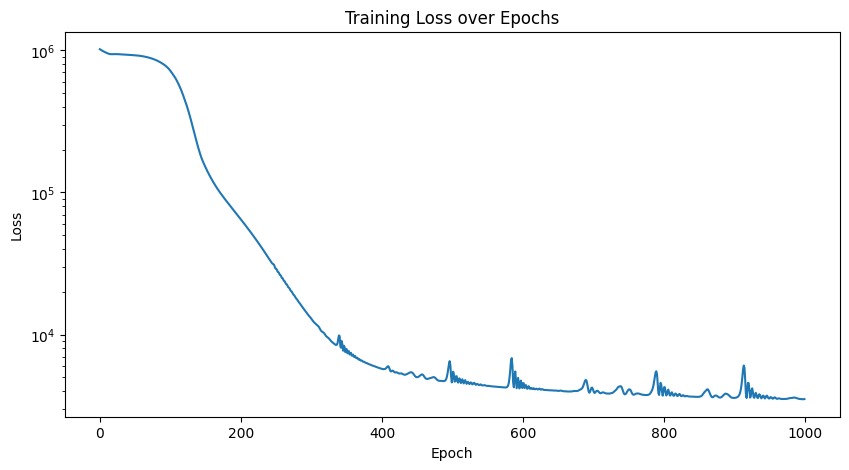

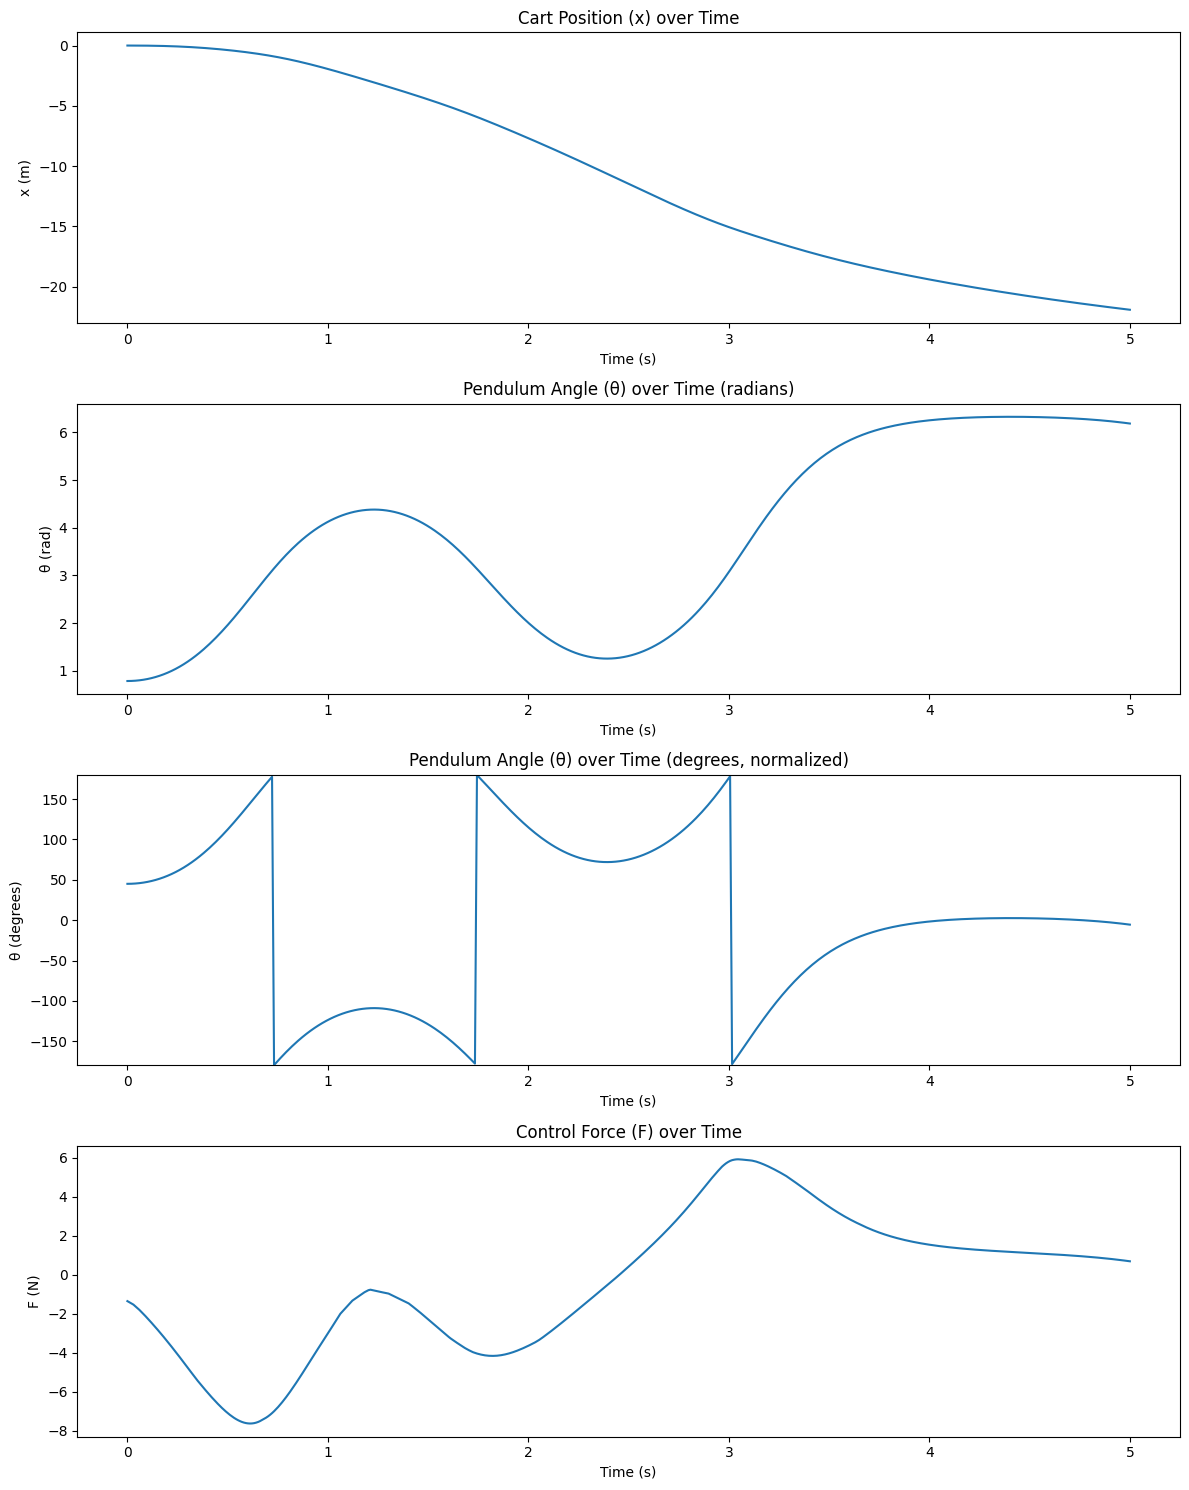

In [ ]:
# Define the neural network model using Equinox
class MLP(eqx.Module):
    layers: list
    final_layer: eqx.Module

    def __init__(self, key):
        keys = random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(4, 16, key=keys[0]),
            eqx.nn.Linear(16, 16, key=keys[1])
        ]
        self.final_layer = eqx.nn.Linear(16, 1, key=keys[2])

    def __call__(self, x):
        for layer in self.layers:
            x = jax.nn.relu(layer(x))
        x = self.final_layer(x)
        return x

# Initialize the model and parameters
key = random.PRNGKey(0)
mlp = MLP(key)

# Define the system of ODEs with neural network control
def pendulum_ode(t, y, mlp, M, m, l, g):
    x, x_dot, theta, theta_dot = y
    state = jnp.array([x, x_dot, theta, theta_dot])
    F = mlp(state).squeeze()  # Use the neural network to compute F
    x_ddot = (F - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * theta_dot**2 * jnp.sin(theta)) / (M + m - m * jnp.cos(theta)**2)
    theta_ddot = (g * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / l
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])

def normalize_angle_degrees(angle_rad):
    angle_deg = jnp.rad2deg(angle_rad)
    return ((angle_deg + 180) % 360) - 180

# Define the cost function
@jax.jit
def loss_fn(mlp, y0, t0, tN, ts, M, m, l, g):
    term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)
    x_sol = solution.ys[:, 0]
    x_dot_sol = solution.ys[:, 1]
    theta_sol = solution.ys[:, 2]
    theta_dot_sol = solution.ys[:, 3]

    # Normalize theta to -180 to 180 degrees
    theta_sol_deg = normalize_angle_degrees(theta_sol)

    # Calculate the index for the last fourth of the data
    last_fourth_index = int(3 * len(theta_sol_deg) / 4)

    # Use only the last fourth of theta_sol for the loss calculation
    theta_sol_last_fourth = theta_sol_deg[last_fourth_index:]

    state_sol = jnp.stack([x_sol, x_dot_sol, theta_sol, theta_dot_sol], axis=1)
    F_sol = jax.vmap(lambda state: mlp(state).squeeze())(state_sol)

    # Calculate loss based on the absolute value of the angle
    angle_error = jnp.abs(theta_sol_last_fourth)
    return jnp.sum(jnp.square(angle_error)) + 0.3*jnp.sum(jnp.square(F_sol))

# Training setup
M = 1.0
m = 0.1
l = 1.0
g = 9.81
y0 = jnp.array([0.0, 0.0, jnp.pi / 4, 0.0])
t0, tN = 0.0, 5.0
ts = jnp.linspace(t0, tN, 500)

# Create the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

@jax.jit
def update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g):
    loss, grads = jax.value_and_grad(loss_fn)(mlp, y0, t0, tN, ts, M, m, l, g)
    updates, opt_state = optimizer.update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, loss

# Training loop
losses = []
for epoch in range(1000):
    mlp, opt_state, loss = update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Simulate with the trained policy
term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
solver = Tsit5()
saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)

# Extract solutions
x_sol = solution.ys[:, 0]
x_dot_sol = solution.ys[:, 1]
theta_sol = solution.ys[:, 2]
theta_dot_sol = solution.ys[:, 3]

# Plot the results
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
plt.plot(ts, x_sol)
plt.title('Cart Position (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')

plt.subplot(4, 1, 2)
plt.plot(ts, theta_sol)
plt.title('Pendulum Angle (θ) over Time (radians)')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')

plt.subplot(4, 1, 3)
theta_sol_deg = normalize_angle_degrees(theta_sol)
plt.plot(ts, theta_sol_deg)
plt.title('Pendulum Angle (θ) over Time (degrees, normalized)')
plt.xlabel('Time (s)')
plt.ylabel('θ (degrees)')
plt.ylim(-180, 180)

plt.subplot(4, 1, 4)
state_sol = jnp.stack([x_sol, x_dot_sol, theta_sol, theta_dot_sol], axis=1)
F_sol = jax.vmap(lambda state: mlp(state).squeeze())(state_sol)
plt.plot(ts, F_sol)
plt.title('Control Force (F) over Time')
plt.xlabel('Time (s)')
plt.ylabel('F (N)')

plt.tight_layout()
plt.show()

Note: In our case we consider F as depending on the 4 states. However, the forcing function may only depend ONLY on time.
For this reason, we have to change the inputs of my force from the states of the system to the time. In this case, the assumption is that the value that I would obtain may not be as precise as before.

Epoch 0, Loss: 7729.38623046875
Epoch 100, Loss: 5142.88037109375
Epoch 200, Loss: 4336.67041015625
Epoch 300, Loss: 4153.263671875
Epoch 400, Loss: 4030.2822265625
Epoch 500, Loss: 3870.330322265625
Epoch 600, Loss: 3588.46728515625
Epoch 700, Loss: 2938.722412109375
Epoch 800, Loss: 1264.51708984375
Epoch 900, Loss: 194.53585815429688


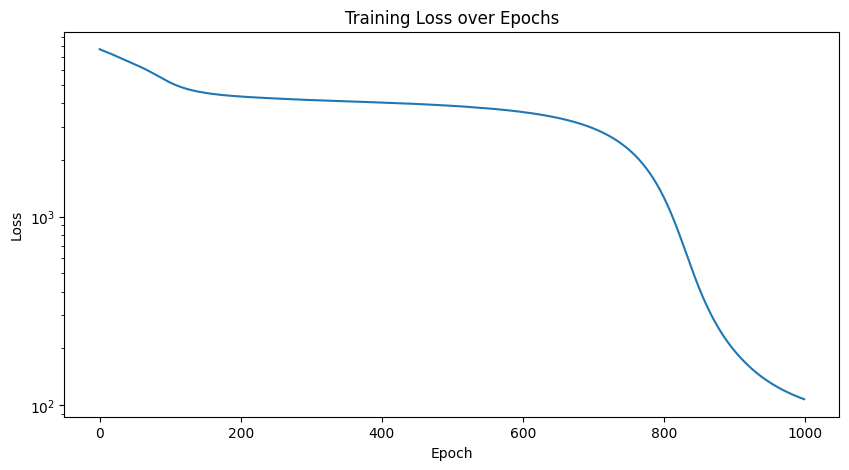

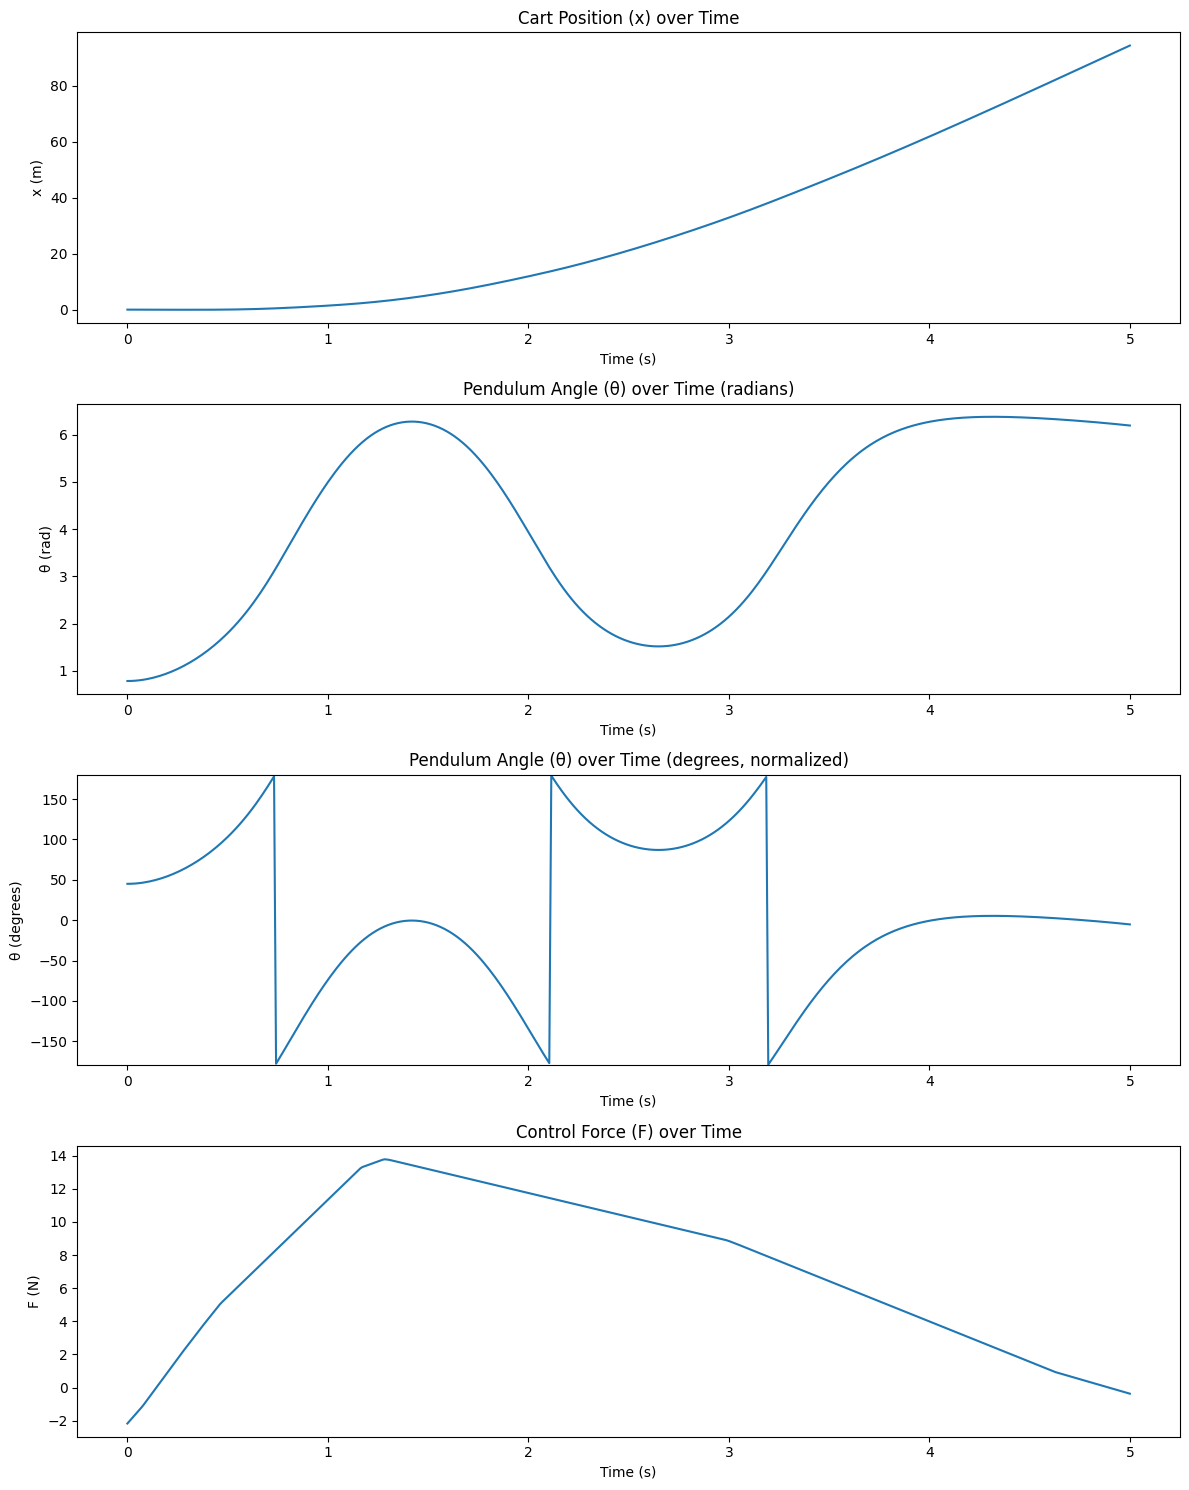

In [ ]:
# Define the neural network model using Equinox
class MLP(eqx.Module):
    layers: list
    final_layer: eqx.Module

    def __init__(self, key):
        keys = random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(1, 16, key=keys[0]),
            eqx.nn.Linear(16, 16, key=keys[1])
        ]
        self.final_layer = eqx.nn.Linear(16, 1, key=keys[2])

    def __call__(self, t):
        x = jnp.array([t])
        for layer in self.layers:
            x = jax.nn.relu(layer(x))
        x = self.final_layer(x)
        return x.squeeze()

# Initialize the model and parameters
key = random.PRNGKey(0)
mlp = MLP(key)

# Define the system of ODEs with neural network control
def pendulum_ode(t, y, mlp, M, m, l, g):
    x, x_dot, theta, theta_dot = y
    F = mlp(t)  # Use the neural network to compute F based on time
    x_ddot = (F - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * theta_dot**2 * jnp.sin(theta)) / (M + m - m * jnp.cos(theta)**2)
    theta_ddot = (g * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / l
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])

def normalize_angle_degrees(angle_rad):
    angle_deg = jnp.rad2deg(angle_rad)
    return ((angle_deg + 180) % 360) - 180

# Define the cost function
@jax.jit
def loss_fn(mlp, y0, t0, tN, ts, M, m, l, g):
    term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)

    theta_sol = solution.ys[:, 2]
    theta_sol_deg = normalize_angle_degrees(theta_sol)

    # Focus on the last quarter of the simulation
    last_quarter_index = int(3 * len(ts) / 4)
    theta_sol_last_quarter = theta_sol_deg[last_quarter_index:]
    ts_last_quarter = ts[last_quarter_index:]

    # Calculate loss based on the angle in the last quarter
    angle_error = jnp.abs(theta_sol_last_quarter)

    # Calculate the control effort over the entire time
    F_sol = jax.vmap(mlp)(ts)

    return jnp.mean(jnp.square(angle_error)) + 0.3 * jnp.mean(jnp.square(F_sol))

# Training setup
M = 1.0
m = 0.1
l = 1.0
g = 9.81
y0 = jnp.array([0.0, 0.0, jnp.pi / 4, 0.0])
t0, tN = 0.0, 5.0
ts = jnp.linspace(t0, tN, 500)

# Create the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

@jax.jit
def update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g):
    loss, grads = jax.value_and_grad(loss_fn)(mlp, y0, t0, tN, ts, M, m, l, g)
    updates, opt_state = optimizer.update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, loss

# Training loop
losses = []
for epoch in range(1000):
    mlp, opt_state, loss = update(mlp, opt_state, y0, t0, tN, ts, M, m, l, g)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Simulate with the trained policy
term = ODETerm(lambda t, y, args: pendulum_ode(t, y, args, M, m, l, g))
solver = Tsit5()
saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=t0, t1=tN, dt0=1e-3, y0=y0, args=mlp, saveat=saveat, max_steps=100000)

# Extract solutions
x_sol = solution.ys[:, 0]
x_dot_sol = solution.ys[:, 1]
theta_sol = solution.ys[:, 2]
theta_dot_sol = solution.ys[:, 3]

# Plot the results
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
plt.plot(ts, x_sol)
plt.title('Cart Position (x) over Time')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')

plt.subplot(4, 1, 2)
plt.plot(ts, theta_sol)
plt.title('Pendulum Angle (θ) over Time (radians)')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')

plt.subplot(4, 1, 3)
theta_sol_deg = normalize_angle_degrees(theta_sol)
plt.plot(ts, theta_sol_deg)
plt.title('Pendulum Angle (θ) over Time (degrees, normalized)')
plt.xlabel('Time (s)')
plt.ylabel('θ (degrees)')
plt.ylim(-180, 180)

plt.subplot(4, 1, 4)
F_sol = jax.vmap(mlp)(ts)
plt.plot(ts, F_sol)
plt.title('Control Force (F) over Time')
plt.xlabel('Time (s)')
plt.ylabel('F (N)')

plt.tight_layout()
plt.show()